# EMAT30008 Scientific Computing

Michael Johnson - fr19042@bristol.ac.uk - 1962648

## Introduction

In this report, we will be show casing the capabilities of code written to solve ODEs, PDEs and performing numerical continuation, As well as this we'll be discussing the design choices and learning process that went along with the development of the code.
## Summary of Software

The software consists of four modules: 
1) integrate: contains solve_to function for integrating ODEs
2) BVP: contains shooting and solve_BVP
3) PDEs : Contains diffusion_solver for solving the diffusion-reaction equation.
4) continuation: contains continuation for solving ODE equilibria/period orbits for varying parameters.

Let's start by importing the necessary libraries for result plotting.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from scipy.optimize import root
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image

%matplotlib inline

#### ODE integration methods

The module `integrate.py` consists of three functions, `euler_step`, `RK4_step` and `solve_to`. `euler_step` and `RK4_step` both increment a solution by a single time step according to the forward euler and fourth order runge-kutta methods respectively. The core function is `solve_to` which calls either `euler_step` or `RK4_step` depending on user input to integrate an ODE over some time span. The user can choose a start and end time, the time-stepping method used and the size of time-step for integrating the chosen ODE with initial condition x0.

We can perform a simple demonstration for two ODEs as outlined in the table below. The code is shown handling different solution dimensions, time spans and parameters alongside the analytical solution.

<style>
table {
  border-collapse: collapse;
  width: 100%;
}
th, td {
  border: 1px solid black;
  padding: 8px;
  text-align: left;
  vertical-align: top;
}
th {
  background-color: #f2f2f2;
}
.math {
  display: block;
  text-align: left;
  margin-bottom: 1em;
}
</style>

<table>
    <tr>
        <th style="width: 15%;"> </th>
        <th style="width: 45%;">ODE Equation</th>
        <th style="width: 40%;">Analytical Solution</th>
    </tr>
    <tr>
        <td></td>
        <td><div class="math">$\dot{x}(t) = x(t)$</div></td>
        <td><div class="math">$ x(t) = x_{0}e^{t} $</div></td>
    </tr>
    <tr>
        <td>Hopf Normal Form:</td>
        <td>
            <div class="math">$\dot{u_1} = \beta u_1 - u_2 + \sigma u_1(u_1^2 + u_2^2)$</div>
            <div class="math">$\dot{u_2} = u_1 + \beta u_2 + \sigma u_2(u_1^2 + u_2^2)$</div>
        </td>
        <td>
            <div class="math">$u_1(t) = \sqrt{\beta} \cos(t+\theta)$</div>
            <div class="math">$u_2(t) = \sqrt{\beta} \sin(t+\theta)$</div>
        </td>
    </tr>
</table>



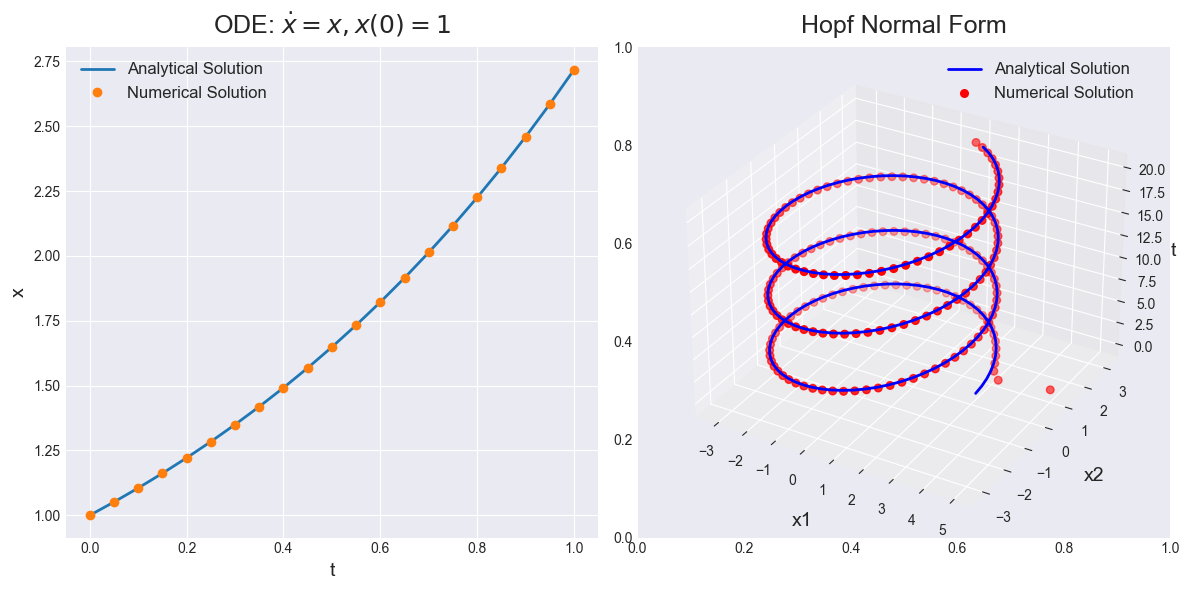

In [5]:
from integrate import solve_to
from functions import f, hopf_normal_form, hopf_normal_form_sol

# Generate and plot results for x' = x, x(0) = 1

result = solve_to(func=f, x0=[1], t=[0, 1], parameters=None, deltat_max=0.05, method='RK4')
x = result.x[0]
t = result.t_space

plt.style.use('seaborn-v0_8-dark')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.plot(t, np.exp(t), linewidth=2, label='Analytical Solution')
ax0.plot(t, x, 'o', markersize=6, label='Numerical Solution')
ax0.set_title('ODE: '+r"$\dot{x} = x, x(0) = 1$", fontsize=18, pad = 10)
ax0.set(xlabel='t', ylabel='x')
ax0.set_xlabel('t', fontsize=14)
ax0.set_ylabel('x', fontsize=14)
ax0.legend(fontsize=12, loc="upper left")
ax0.grid(True)

# Generate and plot results for hopf normal form

beta = 10
theta = 0
result = solve_to(func=hopf_normal_form, x0=[5, 1], t=[0, 20], parameters=[beta, -1], deltat_max=0.1, method='RK4')
x = result.x
t = result.t_space

x_analytical = hopf_normal_form_sol(t, beta, theta)

x1_analytical = x_analytical[0]
x2_analytical = x_analytical[1]

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot(x1_analytical, x2_analytical, t, color='blue', linewidth=2, label='Analytical Solution')
ax1.scatter(x[0], x[1], t, c='r', marker='o', s=30, label='Numerical Solution')
ax1.set_title("Hopf Normal Form", fontsize=18, pad=10)  # Add pad to adjust title position
ax1.set_xlabel('x1', fontsize=14, labelpad=10)
ax1.set_ylabel('x2', fontsize=14, labelpad=10)
ax1.set_zlabel('t', fontsize=14, labelpad=2)
ax1.legend(fontsize=12)

plt.tight_layout()

#### ODE BVP solvers

The module `BVP.py` consists of three functions, `lim_cycle_conditions`, `BVP_solver` and `shooting` with the latter two working to solve boundary value ODE problems. `lim_cycle_conditions` returns an array containing the difference between the final and initial solution for a given ODE as well as the first derivative of the first component at time $t = 0$. This function is then called in shooting which uses a numerical solver such as scipy.optimize.root to solve for and return the conditions for a limit cycle of a chosen ODE. The final function, `BVP_solver`, uses a finite difference analogue to discretize and solve the time invariant diffusion reaction equation given boundary conditions, source term and diffusion coefficient. If the source term is non-linear then the code may prompt the user to choose an initial guess if solver does not converge. `BVP_solver` requires user to set up boundary conditions and domain grid using BoundaryCondition and Grid from `PDEs.py`.

Below we will demonstrate the code isolating a a limit cycle for the hopf normal form ODE (which has a limit cycle for $\sigma = -1$) and predator prey model as well as solving the Bratu problem and a generic LTI reaction-diffusion equation as outlined in the table below:

| ODE name                                  | Governing equation                                          |
|-------------------------------------------|--------------------------------------------------------------|
| Predator Prey Model                       | $\dot{x} = x(1-x) - \frac{axy}{d+x}$, $\dot{y} = by\left(1-\frac{y}{x}\right)$ $ a = 1, b = 0.1, d = 0.1 $ |
| Bratu Problem                             | $D\frac{d^2u}{d x^2} + e^{\mu u} = 0$, $u(0) = u(1) = 0, \mu = 0.01, D = 1 $                                   |
| Generic problem                           | $D\frac{d^2u}{d x^2} + x^2 = 0$,  $\frac{\partial u}{\partial x}(0) = 5 + 2u(0), u(1) = 10, D = 1$                                               |



In [6]:
# Import functions

from BVP import shooting, BVP_solver
from PDEs import BoundaryCondition, Grid
from functions import hopf_normal_form, hopf_normal_form_sol, PPM
import scipy
import numpy as np

# Solve for limit cycles:

hopf_param = [1,-1]
hopf_lim_cycle = shooting(hopf_normal_form,[0.5,0.5,20],[1,-1],scipy.optimize.root)
hopf_init_sol = hopf_lim_cycle.x0
hopf_period = hopf_lim_cycle.T

PPM_lim_cycle = shooting(PPM,[0.5,0.3,20],[1,0.1,0.1],scipy.optimize.root)
PPM_init_sol = PPM_lim_cycle.x0
PPM_period = PPM_lim_cycle.T

# Get results for given limit cycle conditions:

hopf_sol = scipy.integrate.solve_ivp(lambda t,x: hopf_normal_form(x,t,hopf_param),[0,hopf_period],hopf_init_sol,rtol = 1e-6,atol = 1e-6)
PPM_sol = scipy.integrate.solve_ivp(lambda t,x: PPM(x,t,[1,0.1,0.1]),[0,PPM_period],PPM_init_sol,rtol = 1e-8,atol = 1e-8)

hopf_sol_true = hopf_normal_form_sol(np.linspace(0,2*np.pi))

# Solve time-invariant reaction-diffusion equation:

# Problem 1:

grid = Grid(100,0,1)
bc_left = BoundaryCondition('robin',[5,-2],grid)
bc_right = BoundaryCondition('dirichlet',[10],grid)

solution1 = BVP_solver(grid,bc_left,bc_right, 0, 1)

# Bratu Problem: 

bc_left = BoundaryCondition('dirichlet',[0],grid)
bc_right = BoundaryCondition('dirichlet',[0],grid)

solution2 = BVP_solver(grid,bc_left,bc_right,q = lambda x,u: np.exp(0.01*u),D = 1,u_guess = 10)

Now let's plot the results:

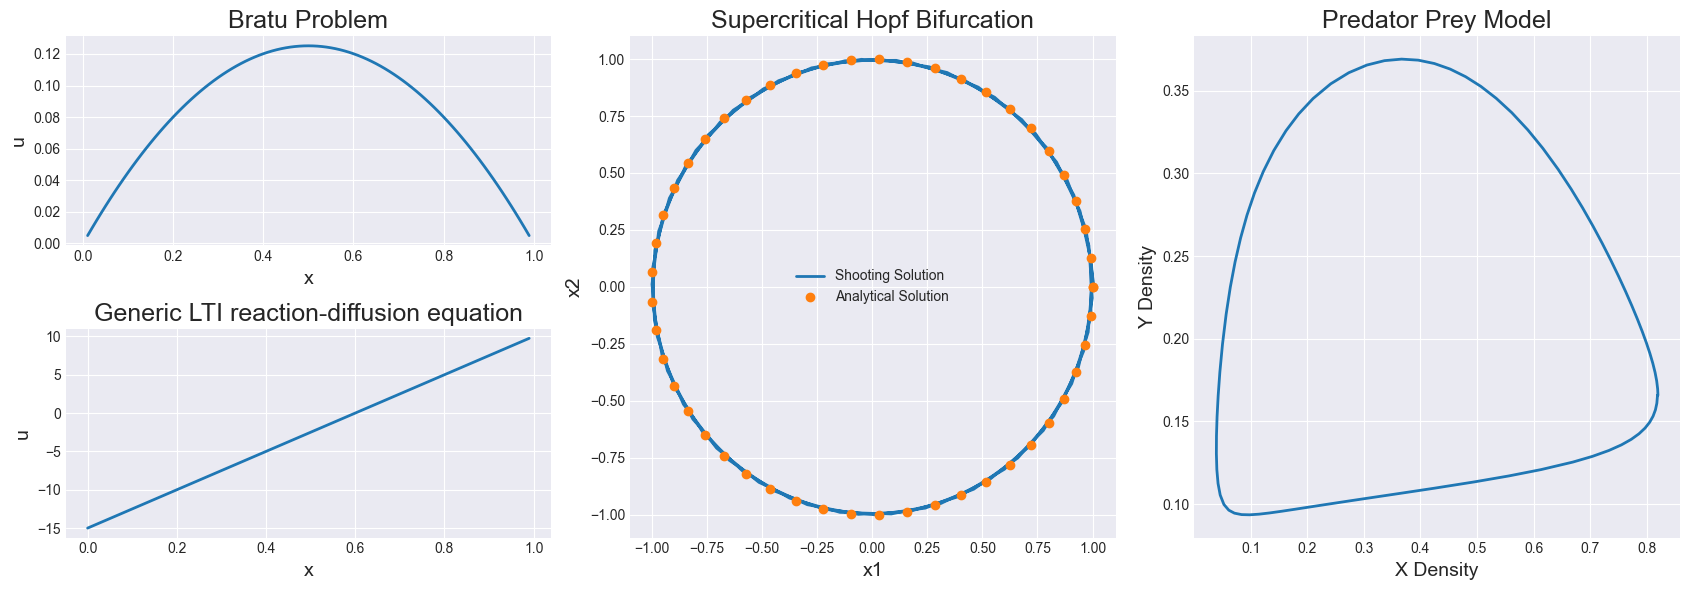

In [7]:
plt.style.use('seaborn-v0_8-dark')

fig = plt.figure(figsize=(17, 6))

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Create the subplots
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[:, 1])
ax4 = plt.subplot(gs[:, 2])

# Plot the data in each subplot
ax1.plot(solution2.x, solution2.u, linewidth=2, label='Numerical Solution')
ax1.set_title('Bratu Problem',fontsize = 18)
ax1.set_xlabel('x',fontsize = 14)
ax1.set_ylabel('u',fontsize = 14)
ax1.grid(True)

ax2.plot(solution1.x, solution1.u, linewidth=2, label='Numerical Solution')
ax2.set_title('Generic LTI reaction-diffusion equation',fontsize = 18)
ax2.grid(True)
ax2.set_xlabel('x',fontsize = 14)
ax2.set_ylabel('u',fontsize = 14)

ax3.plot(hopf_sol.y[0], hopf_sol.y[1],linewidth = 2, label = 'Shooting Solution')
ax3.plot(hopf_sol_true[0], hopf_sol_true[1],'o',label = 'Analytical Solution')
ax3.grid(True)
ax3.legend(loc = 'best')
ax3.set_title('Supercritical Hopf Bifurcation',fontsize = 18)
ax3.set_xlabel('x1',fontsize = 14)
ax3.set_ylabel('x2',fontsize = 14)

ax4.plot(PPM_sol.y[0],PPM_sol.y[1],linewidth = 2)
ax4.grid(True)
ax4.set_title('Predator Prey Model',fontsize = 18)
ax4.set_xlabel('X Density',fontsize = 14)
ax4.set_ylabel('Y Density',fontsize = 14)

# Adjust the layout
plt.tight_layout()

# Display the figure
plt.show()

#### PDE Integration methods

The module `PDEs.py` consists of several functions that aim to solve a one-dimensional diffusion equation with given boundary and initial conditions as well as a source term. The code allows users to choose from various finite difference methods for solving the problem, such as explicit Euler, implicit Euler, Crank-Nicolson, and IMEX (Implicit-Explicit) methods.

The `gen_diag_mat` function generates a diagonal matrix of size NxN using the given entries for the diagonal elements. The `Grid` function creates a grid with specified grid points, grid spacing, and domain limits. The `BoundaryCondition` function sets up the boundary condition type (Dirichlet, Neumann, or Robin) and the corresponding values for each boundary condition.

The `construct_A_and_b` function builds the A matrix and b vector, which are used in the finite difference method based on the given boundary conditions and the grid. The `du_dt` function computes the explicit temporal derivative of u. The main function, `diffusion_solver`, iterates over a specified time range and uses the chosen finite difference method to solve for the solution u(x,t) of the diffusion equation with given boundary conditions, initial conditions, diffusion coefficient, and source term.

The solution is returned as an object containing the solution array u, the time steps array t, and the grid points array x. The user can also choose between dense and sparse storage for the A matrix.

Below we will demonstrate the code working for a range of boundary and initial value problems as well as linear and non-linear source terms, with a variety of finite difference methods to solve the 1d reaction diffusion equation: $$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + q(x,t,u).$$


<table>
  <tr>
    <th style="width: 5%;">#</th>
    <th style="width: 30%;">Left Boundary Condition</th>
    <th>Right Boundary Condition</th>
    <th>Initial<br>Condition</th>
    <th>Source Term</th>
  </tr>
  <tr>
    <td>1</td>
    <td>$u(0,t) = \sin(t)$</td>
    <td>$\frac{\partial u}{\partial x}(1,t) = 2$</td>
    <td>$u(x,0) =$<br>$\sin(2\pi x)$</td>
    <td>$q(x,t,u) =$<br>$0$</td>
  </tr>
  <tr>
    <td>2</td>
    <td>$u(0,t) = 5$</td>
    <td>$u(10,t) = 10$</td>
    <td>$u(x,0) = 0$</td>
    <td>$q(x,t,u) =$<br>$5x^2 + t - \sin(u)$</td>
  </tr>
  <tr>
    <td>3</td>
    <td>$\frac{\partial u}{\partial x}(0,t) = 5 - 2u(0,t)$</td>
    <td>$\frac{\partial u}{\partial x}(5,t) = e^{-t}$</td>
    <td>$u(x,0) = 5$</td>
    <td>$q(x,t,u) =$<br>$2+ t $</td>
  </tr>
</table>


First let's generate the results:


In [8]:
from PDEs import Grid, BoundaryCondition, diffusion_solver

t_steps1 = 100

# problem 1

grid1 = Grid(N=10, a=0, b=1)
bc_left = BoundaryCondition('dirichlet', [lambda t: np.sin(t)], grid1)
bc_right = BoundaryCondition('neumann', [2], grid1)
IC = lambda x: np.sin(2*np.pi*x)

result = diffusion_solver(grid1,bc_left,bc_right,IC,D=1,q=0,dt=0.1,t_steps=1000,method='implicit-euler',storage_type='sparse')

x1 = result.x
u1 = result.u
t_span1 = result.t

# problem 2

t_steps = 1000

grid2 = Grid(N=10, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [5], grid2)
bc_right = BoundaryCondition('dirichlet', [10], grid2)
q2 = lambda x,t,u: 5*x**2 + t - np.sin(u)

result = diffusion_solver(grid2,bc_left,bc_right,initial_condition=0,D=1,q=q2,dt=1,t_steps=t_steps,method='IMEX',storage_type='dense')

u2 = result.u
x2 = result.x
t_span2 = result.t

# problem 3

grid3 = Grid(N=10, a=0, b=5)
bc_left = BoundaryCondition('robin', [5, 2], grid3)
bc_right = BoundaryCondition('neumann', [lambda t: np.exp(-t)], grid3)
q3 = lambda x,t,u: 2 + 50*t
IC = 5

result = diffusion_solver(grid3,bc_left,bc_right,initial_condition=5,D=1,q=q3,dt=0.1,t_steps=t_steps,method='lines',storage_type='sparse')

u3 = result.u
x3 = result.x
t_span3 = result.t


Now, we will plot the time $t$ against domain $x$ against solution $u$ using plotly's 3d plotting library:

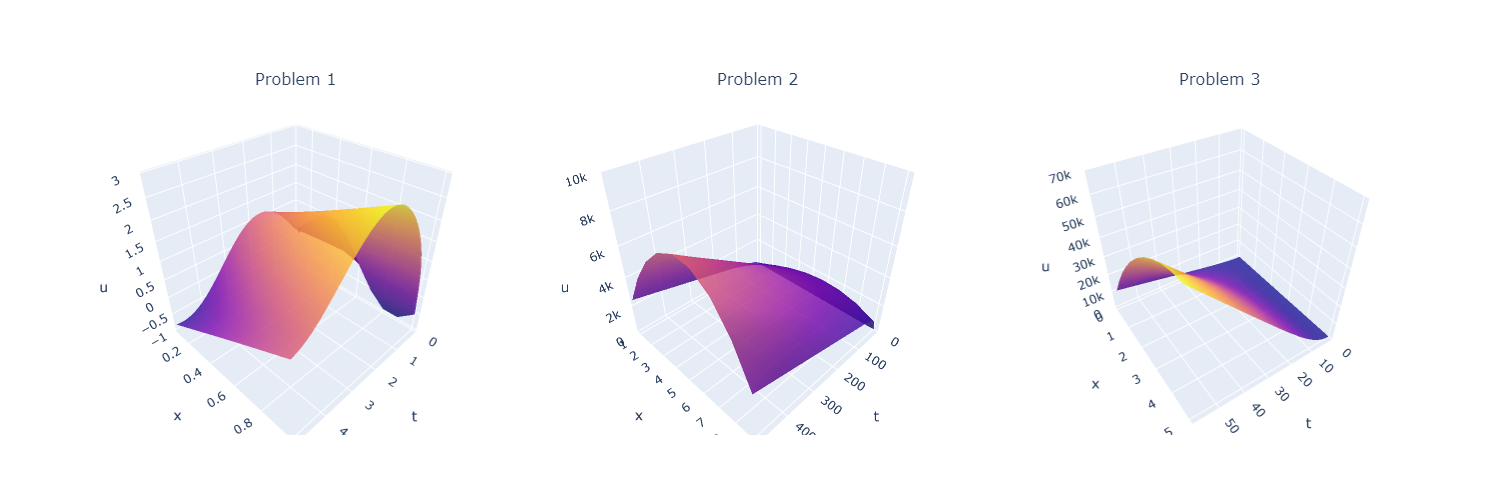

In [9]:
# Create a 1x3 subplot layout
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]], 
                    subplot_titles=('Problem 1', 'Problem 2', 'Problem 3'),
                    horizontal_spacing=0)

# Add the Surface plots to each subplot
fig.add_trace(go.Surface(z=u1, x=t_span1, y=x1, opacity = 0.8), row=1, col=1)
fig.update_traces(showscale=False)
fig.add_trace(go.Surface(z=u2, x=t_span2, y=x2,opacity = 0.8), row=1, col=2)
fig.update_traces(showscale=False)
fig.add_trace(go.Surface(z=u3, x=t_span3, y=x3, opacity = 0.8), row=1, col=3)
fig.update_traces(showscale=False)


# Update the overall layout
fig.update_layout(
    scene=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 5],title_font=dict(size=14))
    ),
    scene2=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 500],title_font=dict(size=14)),
        zaxis=dict(range=[0, 10000],title_font=dict(size=14))
    ),
    scene3=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 60],title_font=dict(size=14)),
        zaxis=dict(range=[0, 70000],title_font=dict(size=14)),
        camera=dict(
            eye=dict(x=1, y=1.5, z=1.5))
    ),
    autosize=False,
    width=1500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90)
)
img_bytes = pio.to_image(fig, format='png', width=1500, height=500, engine="kaleido")
Image(img_bytes)

We can better visualise the time dependant boundary conditions by animating the solution in time for problem 1:

*(Please note the HTTP server only runs for ten seconds each time the code is executed so to get a working link the following code must be run again).*

In [11]:
from make_animation import view_animation

view_animation(x1, u1, grid1, t_steps1, title = 'Problem 1')

MovieWriter imagemagick unavailable; using Pillow instead.


Animation available at: http://localhost:54742/animation.gif


127.0.0.1 - - [26/Apr/2023 21:43:44] "GET /animation.gif HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2023 21:43:45] "GET /favicon.ico HTTP/1.1" 200 -


#### Continuation

`continuation.py` contains `gen_sol_mat`, `find_initial_conditions`, `predictor` and `corrector` which all contribute towards the core function: `continuation`. Using `continuation` the user can track either equilibria or the limit cycle conditions (x0 and period) of a given ODE system. The user chooses a parameter to vary by indicating its index in the `par0` argument. Continuation methods available to user include natural parameter and pseudo-arclength. Other customization options include the number of steps and solver to use. At the moment the code only supports scipy.optimize.root.

Below we will use `continuation` to solve a basic single parameter ODE, track limit cycle conditions of the predator-prey model (for which an example limit cycle will be plotted) and solutions of the Bratu problem as outlined in the table below:

<style>
table {
  border-collapse: collapse;
  width: 100%;
}
th, td {
  border: 1px solid black;
  padding: 8px;
  text-align: left;
}
th {
  background-color: #f2f2f2;
}
.math {
  display: inline-block;
  text-align: center;
}
</style>

|                     | ODE Equation                                                                                      | Varying Parameter|
|---------------------|---------------------------------------------------------------------------------------------------|-------------------|
|                     | <div class="math">${\dot{x}}^3 - x + \alpha = 0$</div>                                             |  $\alpha \in [-2, 2] $ |
| Predator-Prey Model | <div class="math">$\dot{x} = x(1 - x) - \frac{axy}{d + x}$<br/>$\dot{y} = by\left(1 - \frac{x}{y}\right)$</div>| $ a \in [1,3.25] $|
| Bratu Problem       | <div class="math">$\frac{d^2u}{dx^2} + e^{\mu u} = 0,$ <br> $u(0) = u(1) = 0$</div>                     |     $\mu \in [0,0.037] $ |



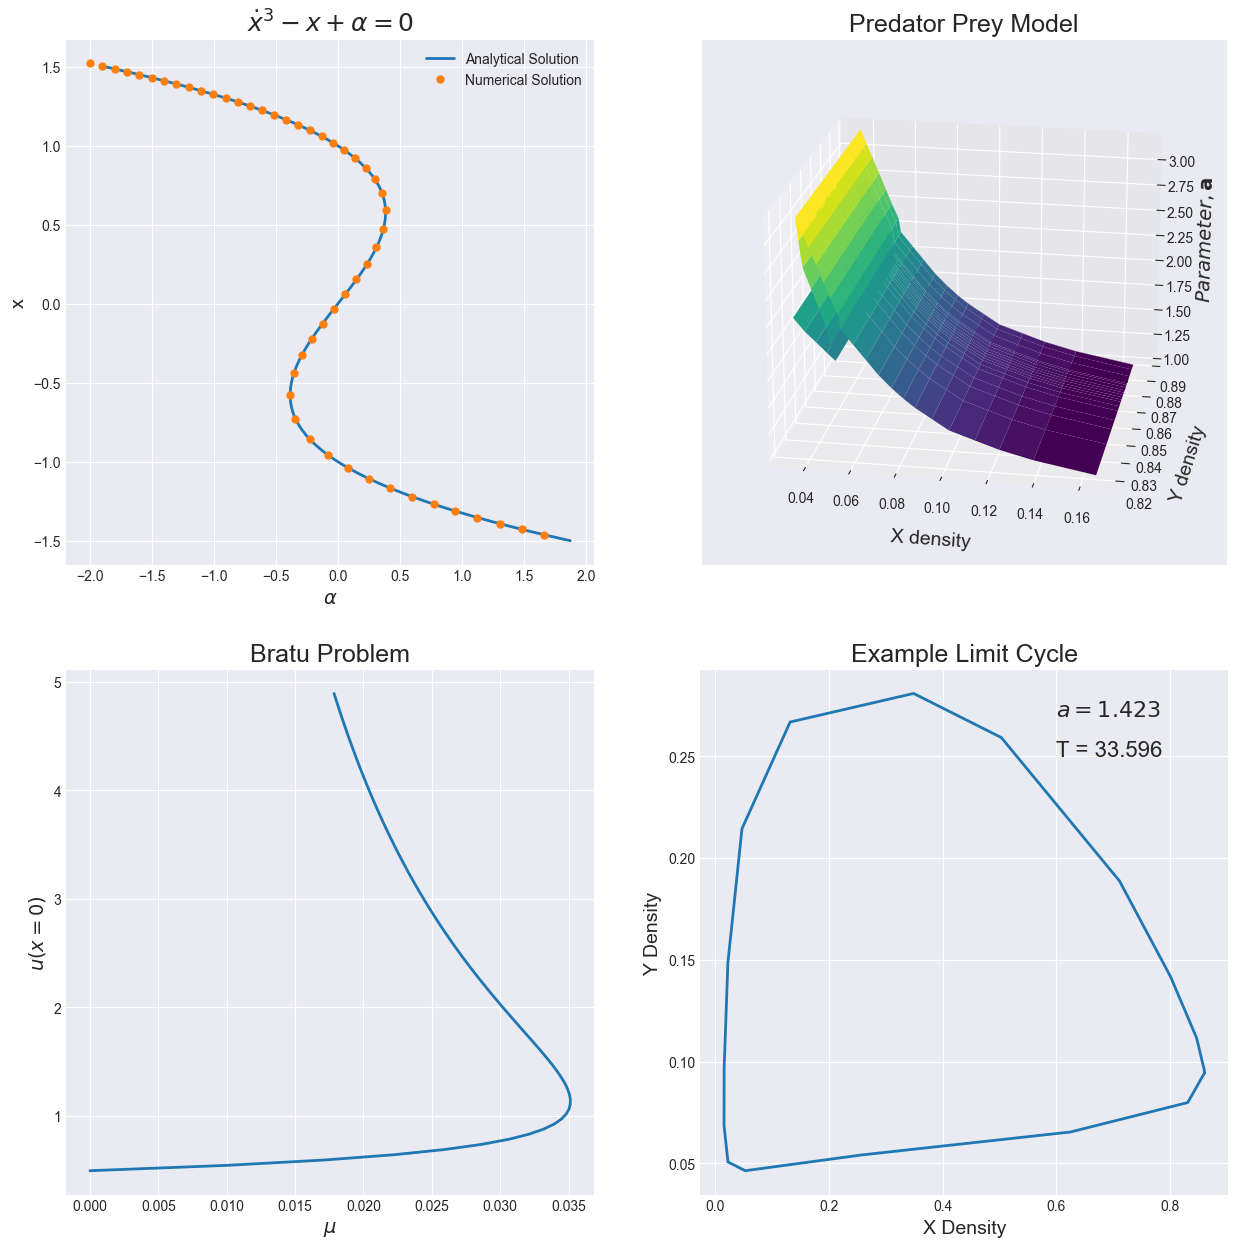

In [10]:
from continuation import continuation
from functions import bratu, h, PPM
from PDEs import Grid, BoundaryCondition, construct_A_and_b
from scipy.integrate import solve_ivp

plt.style.use('seaborn-v0_8-darkgrid')

y = np.linspace(-1.5,1.5,100)

result = continuation(h,x0 = [1],par0 = [-2],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 50,
                   solve_for = 'equilibria')
u = result.u
alpha = result.alpha

fig = plt.figure(figsize=(15, 15))

# Create the first plot
ax0 = fig.add_subplot(2, 2, 1)
ax0.plot(y - y**3, y, label='Analytical Solution', linewidth=2)
ax0.plot(alpha, u[0], 'o', markersize=5, label='Numerical Solution')
ax0.set_title(r"$\dot{x}^3 - x + \alpha = 0$", fontsize=18)
ax0.set(xlabel=r'$\alpha$', ylabel='x')
ax0.xaxis.label.set_size(14)
ax0.yaxis.label.set_size(14)
ax0.legend(loc="best")

# Numerical continuation on the PPM problem for limit cycles

result = continuation(PPM,x0 = [0.5,0.5,20],par0 = [1,0.1,0.1],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 30,
                   solve_for = 'limit_cycle')
u = result.u
alpha = result.alpha

# Create the 3D axis for the middle plot

ax1 = fig.add_subplot(2, 2, 2, projection='3d')

# Create a 3D surface plot of u[0] against u[1] against u[2]

X, Y = np.meshgrid(u[1], u[0])
Z = np.array([alpha for _ in range(len(u[0]))])

ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_title("Predator Prey Model", fontsize=18)
ax1.set_xlabel('X density', labelpad=10,fontsize = 14)  # Add padding to the axis label
ax1.set_ylabel('Y density', labelpad=10,fontsize = 14)  # Add padding to the axis label
ax1.set_zlabel(r"$Parameter,  \mathbf{a}$", labelpad=5, fontsize = 14)  # Add padding to the axis label
ax1.view_init(elev=20, azim=-80)  # Adjust the viewing angle

# Example limit cycle found through continuation

results = continuation(PPM, [0.5,0.5,20],[1,0.1,0.1],vary_par=0,step_size=0.1,max_steps=20,solve_for='limit_cycle')
#%%

x0 = results.u[:-1]
T = results.u[-1]
alpha = results.alpha
idx = 5
result = solve_ivp(lambda t,x: PPM(x,t,[alpha[idx],0.1,0.1]),[0,T[idx]],x0[:,idx])


ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(result.y[0], result.y[1],linewidth = 2)
ax3.set_title("Example Limit Cycle", fontsize=18)
ax3.set(xlabel='X Density', ylabel='Y Density')
ax3.text(0.6,0.27, r"$a = 1.423$", fontsize=16)
ax3.text(0.6,0.25, 'T = ' + str(T[idx].round(3)), fontsize=16)
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)

# Numerical continuation on Bratu problem

grid = Grid(N=100, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [lambda t: 5],grid);bc_right = BoundaryCondition('dirichlet',[lambda t: 10],grid)
A,b = construct_A_and_b(grid,bc_left,bc_right)
dx = grid.dx
u0 = np.zeros(len(grid.x[1:-1]))

result = continuation(bratu,
    x0 = u0,  
    par0=[0,1,dx,A],  
    vary_par=0,  
    step_size=0.01,  
    max_steps=100,  
    solve_for = 'equilibria')

u=result.u
alpha = result.alpha

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(alpha, u[0],linewidth = 2)
ax2.set_title("Bratu Problem", fontsize=18)
ax2.set(xlabel=r"$\mu$", ylabel=r"$u(x=0)$")
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

## Key Software Decisions 

#### General Design

Throughout all the functions developed, the user is able to customize the function to their needs. This is done by passing arguments to the functions. For example, in `diffusion_solver`, the user can choose the finite difference method, the boundary conditions, the initial conditions, the source term, the diffusion coefficient, the time range, the number of time steps, the grid spacing, the grid points, and the domain limits all using arguments. This allows the user to solve a wide range of problems using the same function. 

However whilst this does neatly package all functionality in one place, the user might be overwhelmed by all the arguments and it may be easy for code to become less readable, this can be mitigated by separating functionality as attributes of a class, for example `diffusion_solver(grid,bc_left,bc_right,initial_condition,q,D,dt,t_steps,method='IMEX',storage='sparse')` could be implemented as `diffusion_solver.sparse.IMEX(grid,bc_left,bc_right,initial_condition,q,D,dt,t_steps)`. This method was not persued in order to keep all functions consistent.

All functions are accompanied by a docstring which allows for the user to easily understand what each function does and what arguments are required. As well as this, type annotation sees liberal use, this improves the user experience by allowing them to quickly see what type of variable is required for each of argument as well as what type of return variable is expected. Throughout the code, error handling is integrated at every stage to provide a robust experience to the user; invalid inputs are caught and the user is informed of what they have done wrong.

Universally throughout the code, ODE parameters are passed using an array of values. Using the same data type for parameters as other variables allows for seamless interaction, however a more intuitive approach would be to pass parameters as a dictionary, this would allow for the user to specify which parameter they are changing. For example, in `continuation`, the user must specify the index of the parameter they wish to vary, this is not intuitive and could be improved by passing a dictionary of parameters. This method was not persued as it would require a complete rework of the codebase.

The way ODEs are passed to all the functions is as a function f(x,t,parameters). It would have been better to input ODEs using more standard API such as `scipy.integrate.solve_ivp` which takes ODEs of the form `f(t, y,*args)`. This would have allowed for the user to use the same ODE function for all solvers. This method was not persued as it would also require fundamental changes to the codebase.

All major functions in this package output objects. This is done to allow for the user to easily access the results of the function. It also allows more flexibility for expanding output of a function, for instance if a function outputs an object, the user can easily add more attributes to the class without having to change the function. Another design decision made as standard across all solvers is to initialise the solution array with zeros, this was done as part of memory optimization to reduce the number of operations required to solve the problem.

#### Integration

`solve_to` is a straight forward function that calls `euler_step` or `RK4_step` to integrate an ODE over a time range. The ODE must be passed in the form f(x,t,parameters) and the function is accompanied with a docstring to guide the user. All integration was initially done from time $ t = 0$ however this was changed to accept user input that determines initial time, this makes the solver more flexible in solving a wide range of ODE problems.

Users can set the time-step `deltat_max` to achieve more or less accurate results and that take less or more time to reach. A different approach could have been to input the number of time-steps to use, however setting $\delta t$ provides a more intuitive result. The integration method is currently passed as a string `RK4_step` or `euler_step`. This restricts the user from building and choosing their own stepper or perhaps importing a stepper from a library such as RK45. This method was not persued in order to make the code more robust from invalid user input.

A custom `solve_to_result` class is defined and returned by the `solve_to` function, which includes the solution array `x` and the time steps array `t_space` as attributes. This design choice provides a structured and convenient way to access the results of the integration process.

#### Continuation and Shooting

As part of `BVP.py`, `shooting` uses a root finding algorithm to solve `lim_cycle_conditions`, a function that returns the necessary conditions for a limit cycle. The code is straight-forward and requires minimal user interface. If the solver fails to converge to a solution then an error message is returned to the user indicating them as such. `shooting` returns an object with attributes `x0` and `T` representing the starting conditions and period of the limit cycle respectively, this intuitive output should make it easy for users to take this data and use it in plotting the limit cycle.

To perform numerical continuation the user can call `continuation` which takes input from the user and returns an object with attributes `alpha` and `u` which contain the parameter values and solution respectively. Returning these values as two separate arrays allows for more convenient plotting of the solution for the user. The code for continuation is higly modular, with nearly all functionality being taken out of the continuation function and spread across the other functions in `continuation.py`. This allows for easy troublshooting of problems and a clear structure, as well as room in the future for expanding the code to handle more features. 

The user can choose to solve for limit cycle conditions or equilibria and this is passed with a string input, doing it this way makes the user interface more intuitive. The limits to vary the chosen parameter between are defined by a starting value of the parameter and a step size. In pseudo-arclength continuation, step size is arbitrary after the first two solutions are found, meaning that the user cannot directly tell the code what two values to vary the parameter between.

Whilst this is less user friendly it makes the code more robust and able to handle scenarios where no solution is present regardless of user input. With this being said, the way the code is set up would mean that implementing a normalization stage into `predictor` that ensures a constant `step_size` would not be difficult. If the user has chosen to solve for limit cycles then a guess for period must be provided in the same array as the initial solution guess, this makes user input more compact and leads to less clutter when calling `continuation`. The user decides which paramter to vary by indicating its index in `par0`, this is less intuitive and requires the user to know what order parameters when they're unpacked in their ODE function, however leads to much cleaner and concise code.

Currently the code is set up to take an input for `solver`, whilst the code only supports `scipy.optimize.root` for the time being, this does lay the foundation for future expansions in compatibility for other solvers such as `scipy.optimize.fsolve`.

#### Finite Difference Solvers

The finite difference solvers included in this package are `BVP_solver` and `diffusion_solver`. To solve boundary value PDE problems, a matrix formulation is used in all cases. For instance, below is the finite difference analogue for explicit euler: $$ \mathbf{u_{n+1}} = \frac{\delta tD}{\delta x^2}(\mathbf{Au_{n}} + \mathbf{b}) + \delta tq(\mathbf{x},t,\mathbf{u}) + \mathbf{u_{n}}. $$ Where A is a tri-diagonal matrix and b is a vector. In both finite difference solvers developed, boundary conditions are passed to the function as an object generated by the `BoundaryCondition` function where the user specifies the type of boundary condition with a str input and the associated values. Alternatively these conditions could be passed as arguments directly into the solvers, whilst this would be more convenient for the user, requiring the user to create a boundary condition object separately allows for more flexibility in the future. For example, if the user wanted to solve a problem with a boundary condition that is not currently supported, they could create a new boundary condition class and pass this to the solver, in addition to this the structure of the code becomes much cleaner.

The attributes of the object returned by BoundaryCondition contain information for how `construct_A_and_b` builds the A and b matrices as part of the finite difference analogue: namely the adjusted A entries and information on the dimension of the problem (if dirichlet condition set then dimension reduced by one). Before adjusting for boundary conditions, the A matrix is constructed initially using a separate function `gen_diag_mat` where input can be adjusted to generate different values along the diagonals, allowing the possibility in the future to use other higher order methods such as third and fourth order FTCS schemes. The matrix b is returned as a function and treated as such in all code even if user inputs constants. This allows for cleaner code that simply converts user input into a function if its not already one and applies to all scenarios.

This same principle is applied to the source term `q` and initial conditions `initial_condition`, i.e. the user can pass a function or a constant and the code will convert it to a function in the latter case. This allows for cleaner code and more flexible inputs. The decision was made to allow handling for both sparse and dense matrices which is achieved through `if` statements that influence matrix multiplication, solvers and generators depending on user input, meaning that the same code can be used for dense and sparse, removing the need for code to be repeated. Both dense and sparse matrices have advantages over eachother in certain scenarios and the user can accomodate for these occasions. Furthermore the user can choose from a mixture of explicit, implicit and semi-implicit methods for solving the diffusion equation, this allows the user total freedom in choosing the most appropriate method for their problem.

Various design decisions were made to ensure stability of the problem regardless of the user input. For instance, the time-step size $\delta t$, is automatically recalculated as $\frac{\delta x^2}{D}$ if `explicit-euler` method is chosen and the user inputted value of $\delta t$ leads to oscillations. In addition to this the method of lines makes use of `scipy.integrate.solve_ivp` which takes care of the time-step restriction.

The code handles errors with grace, for any invalid user input both `BVP_solver` and `diffusion_solver` will raise a `TypeError` or `ValueError` with an informative message to let the user know what input needs to be adjusted, this makes the code more user friendly and easier to troubleshoot.

## Reflective learning log

thinking with a purpose
being critical, but not negative
analysing how effective your learning is
questioning and probing
making judgements and drawing conclusions.

implications of what you learned
what you would do differently. 
The format is up to you (e.g. paragraphs or bullet points); the content is more important.

#### 1) What did I learn about the mathematical algorithms? I.e., solving boundary value problems, numerical ill-conditioning, etc.

- Sometimes code is working well, but chosen parameters are not appropriate for the problem
- Different methods of solving boundary value problems: matrix formulation/ multiple for loops, 
- root finding for non-linear problems
- ill conditioned e.g. double neumann boundary conditions

During this project my understanding of mathematical algorithms has improved considerably. Understanding of ODE systems and how they interact with different parameters has broadened my knowledge of the subject on how different systems can be solved and how they behave. One area of note is in how mathematical problems are formulated, for example finite difference can be presented to a solver as a matrix system of equation or for loops can iterate over the domain and time and it has become clear to me that certain formulations lead to more efficient problem solving and more compact code. Another import development in my learning was in recognising the difference between broken code and an ill-conditioned problem. Its not always the case that if code is outputting unintended results then this is the fault of the code, for instance the reaction-diffusion equation with double neumann boundary conditions has no unique solution, and the predator prey model has no limit cycle for b>0.27. This has led me to recognise that continuation is a fantastic tool in visualising how a problem evolves given a varying parameter. 

#### 2) What did I learn about software engineering? How have I progressed in my abilities?

- Different types of data (numpy array vs list etc.)
- Memory efficient (pre-allocating code)
- Error handling
- profiling
- testing
- documentation (docstrings,type annotation, commenting)

#### 3) What are the short-term implications of what I've learnt?

- Useful in future units
- useful in understanding the reaction-diffusion equation and how boundary conditions affect the solution

#### 4) What are the long-term implications of what I've learnt?

- Useful in future software development projects
        -> how to structure code
        -> how to write documentation
        -> how to write tests
        -> how to use version control
        -> how to write a package
        -> how to profile code
        -> how to do reflective learning
        -> writing a report in a jupyter notebook
        -> how to set up a respository

- deeper understanding of ODE systems

#### 5) What would I have done differently if I started the unit over again?

- setup functions as f(t,x,args) instead of f(x,t,args) to be consistent with scipy
- setting up everything as a class:
        limit cycle, equilibria = attributes of a continuation class
        imex, explicit_euler, implicit_euler, lines, crank_nicolson = attributes of diffusion_solver class
-solve_to input stepper directly as function (allows user to build and choose their own stepper)
- modularize literally everything

#### 6) What will I do differently in the future?
- comment code much more as I write it
- write tests as I write code
- write documentation as I write code
- use version control from the start
- use a linter from the start
- use profiling more actively to optimize code